In [1]:
from pyreto_db import documents
import mongoengine as me
from bson.objectid import ObjectId
import gzip
from bson.json_util import loads
import json
import os
import numpy as np
import pandas
import bson
from ipywidgets import IntProgress
from IPython.display import display
import pygmo as pg
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns

# Import the data into a local mongodb

In [2]:
me.connect('water-energy')

MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True, read_preference=Primary())

In [3]:
documents.Search.drop_collection()
documents.Individual.drop_collection()

In [10]:
f = IntProgress(min=0, max=100) # instantiate the bar
display(f) # display the bar

def import_search(directory, name=None):
    
    #_, search_id = os.path.split(directory)
    
    if name is None:
        name = directory
    print('Adding search: {}'.format(name))
    search = documents.Search.objects(name=name).first()
    print(search)
    if search is not None:
        return search  
    
    files = os.listdir(directory)
    if 'search.bson' not in files:
        return
        
    with open(os.path.join(directory, 'search.bson')) as fh:
        search_data = json.load(fh)
        search_data['name'] = name
        search = documents.Search(**search_data)
        search_oid = search.save()
        
    f.max = len(files)

    for i, fn in enumerate(files):
        base, ext = os.path.splitext(fn)
        if base == 'search' or ext != '.gz':
            continue

        with gzip.open(os.path.join(directory, fn), mode='rt') as fh:
            individual_data = loads(fh.read())
            for metric in individual_data['metrics']:
                if 'dataframe' in metric:
                    del metric['dataframe']
                    #metric['dataframe'] = pandas.read_msgpack(metric['dataframe'])

            individual = documents.Individual(search=search, **individual_data)
            individual.save()    
        f.value = i+1
    
    return search_oid

for folder in ('json', ):
    out_folder = os.path.join(folder, 'outputs') 

    if not os.path.isdir(out_folder):
        continue
    
    for file in os.listdir(out_folder):
        result_folder = os.path.join(out_folder, file)
        if not os.path.isdir(result_folder):
            continue
    
        print(folder, file)
        import_search(result_folder, name='{}-{}'.format(folder, file[:8]))



IntProgress(value=0)

json b6b95ccc1fd541b688573a1a31640725
Adding search: json-b6b95ccc
Search object
json d060e9cbfb2e4e44905d8d6b5dc06ae5
Adding search: json-d060e9cb
None


In [11]:
for search in documents.Search.objects.no_cache().all():
    print(search.name, search.started_at)

json-b6b95ccc 2018-11-07 16:03:04.971000
json-d060e9cb 2018-11-08 13:36:29.818000


In [12]:

def get_objectives():
    
    data = {}
    for search in documents.Search.objects.no_cache().all():
        df = search.objectives_to_dataframe()
        #df.index.name = 'individual'
        #df.reset_index(inplace=True)
        
        ndf, dl, dc, ndr = pg.fast_non_dominated_sorting(df.values)
        indices = ndf[0]        
        
        
        data[search.name] = df.iloc[indices, :]
        print(search.name, len(df), len(data[search.name]))
        
    return pandas.concat(data, names=['search_id', 'individual']).reset_index()



objectives = get_objectives()

objectives.head(25)

json-b6b95ccc 7996 5806
json-d060e9cb 10628 7421


,search_id,individual,battery_capacity_recorder,energy_deficit_frequency,energy_total_waste,reservoir_capacity_recorder,water_deficit_frequency
0,json-b6b95ccc,5be3f269e2684b4b086ebe0b,4.466714,0.632877,20548.938672,147.023986,0.0
1,json-b6b95ccc,5be3f269e2684b4b086ebe0c,226.183274,0.523288,14688.236177,247.480616,0.0
2,json-b6b95ccc,5be3f269e2684b4b086ebe0d,85.773481,0.202740,19956.379054,455.261297,0.0
3,json-b6b95ccc,5be3f269e2684b4b086ebe0e,94.511117,0.298630,19403.508978,202.297921,0.0
4,json-b6b95ccc,5be3f269e2684b4b086ebe10,13.675299,0.413699,20408.089260,477.953623,0.0
5,json-b6b95ccc,5be3f269e2684b4b086ebe12,167.146727,0.561644,15748.916940,197.655229,0.0
6,json-b6b95ccc,5be3f269e2684b4b086ebe13,49.815034,0.515068,19280.770026,312.778851,0.0
7,json-b6b95ccc,5be3f269e2684b4b086ebe14,25.998815,0.608219,19823.651049,9.734702,0.0
8,json-b6b95ccc,5be3f269e2684b4b086ebe15,170.655478,0.465753,16552.989270,124.684210,0.0
9,json-b6b95ccc,5be3f269e2684b4b086ebe16,15.431686,0.386301,20402.041146,209.703731,0.0


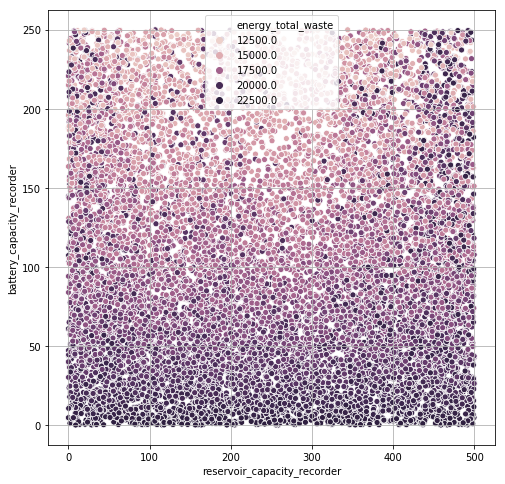

In [13]:
fig, ax = plt.subplots(figsize=(8, 8))

sns.scatterplot(x='reservoir_capacity_recorder', y='battery_capacity_recorder', hue="energy_total_waste", data=objectives, ax=ax)
ax.grid()


In [8]:
search.progression_stats(end=None, periods=10, freq='m').plot(subplots=True, figsize=(12, 6))

KeyboardInterrupt: 

In [14]:


def write_polyvis(individuals, filename):
    """ Write a polyvis CSV file. """

    header = None

    all_data = []
    for i, individual in enumerate(individuals):
        # TODO make this better.
        if i % 10 > 0:
            continue
            
        data = {'ID': individual.id}
        for metric in individual.metrics:
            # TODO distinguish between optimised & tracked

            direction = 'MIN' if metric['minimise'] else 'MAX'
            name = metric['name'].replace('_', '-')
            mtype = 'MO' if metric['objective'] else 'MT'
            data['{}_{}_{}'.format(mtype, direction, name)] = metric.get_value()

        for variable in individual.variables:
            name = variable['name'].replace('_', '-')
            data['DEC_XXX_{}'.format(name)] = variable.get_value()

        all_data.append(data)

    df = pandas.DataFrame(all_data)

    df.set_index('ID', inplace=True)

    df.to_csv(filename)
    
    
iid = '5be3029d6cd3287175056039'
#iid = '5b8c6d876cd328223e5a208d'

for search in documents.Search.objects.no_cache().all():
    print(search.name, search.started_at)
    i = search.non_dominated_individuals()
    #i = documents.Individual.objects(search=search).all()
    write_polyvis(i, f'water-energy-polyvis-{search.name}.csv')

json-b6b95ccc 2018-11-07 16:03:04.971000
json-d060e9cb 2018-11-08 13:36:29.818000
